In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

data = pd.read_csv("housing.csv")

In [2]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
# View data and find NaN values

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
# We can drop NaN since there are so few

data.dropna(inplace = True)

In [5]:
# We will one-hot encode the ocean_proximity column to make it usable

data.ocean_proximity.value_counts()
data = data.join(pd.get_dummies(data.ocean_proximity)).drop(['ocean_proximity'], axis = 1)
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,False,False,False,True,False
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,False,False,False,True,False
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,False,False,False,True,False
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,False,False,False,True,False
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,False,False,False,True,False


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

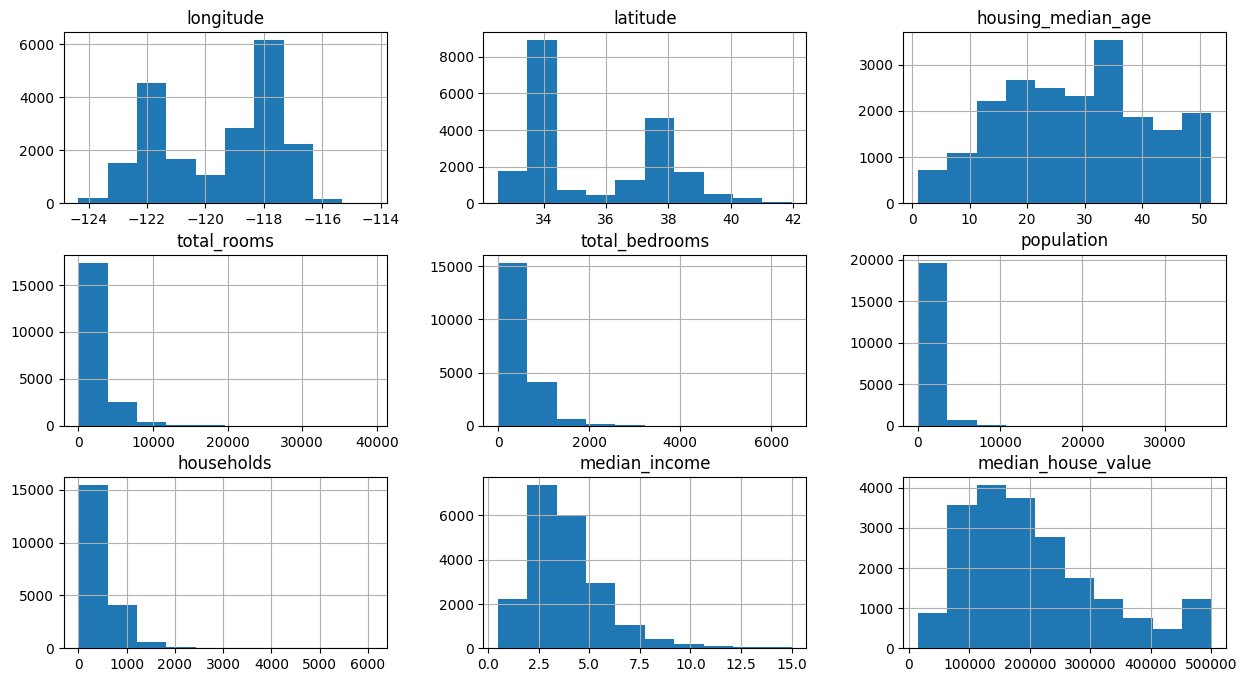

In [6]:
# Can see correlation with target variable

data.hist(figsize=(15,8))

<Axes: >

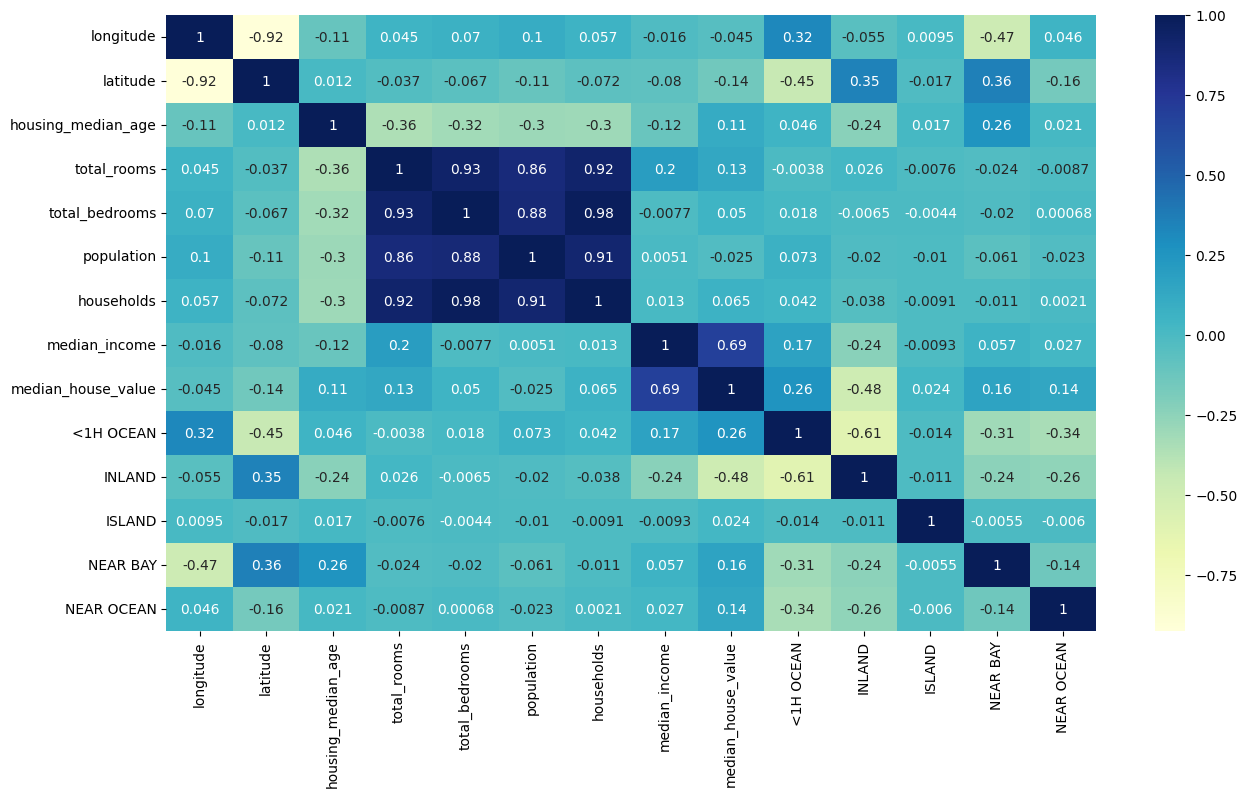

In [7]:
plt.figure(figsize=(15,8))
sns.heatmap(data.corr(), annot=True, cmap='YlGnBu')
# Can see all darker-blue colored boxes show high correlation (ex. median income with house value)
# Can also see yellowish boxes are negatively correlated

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

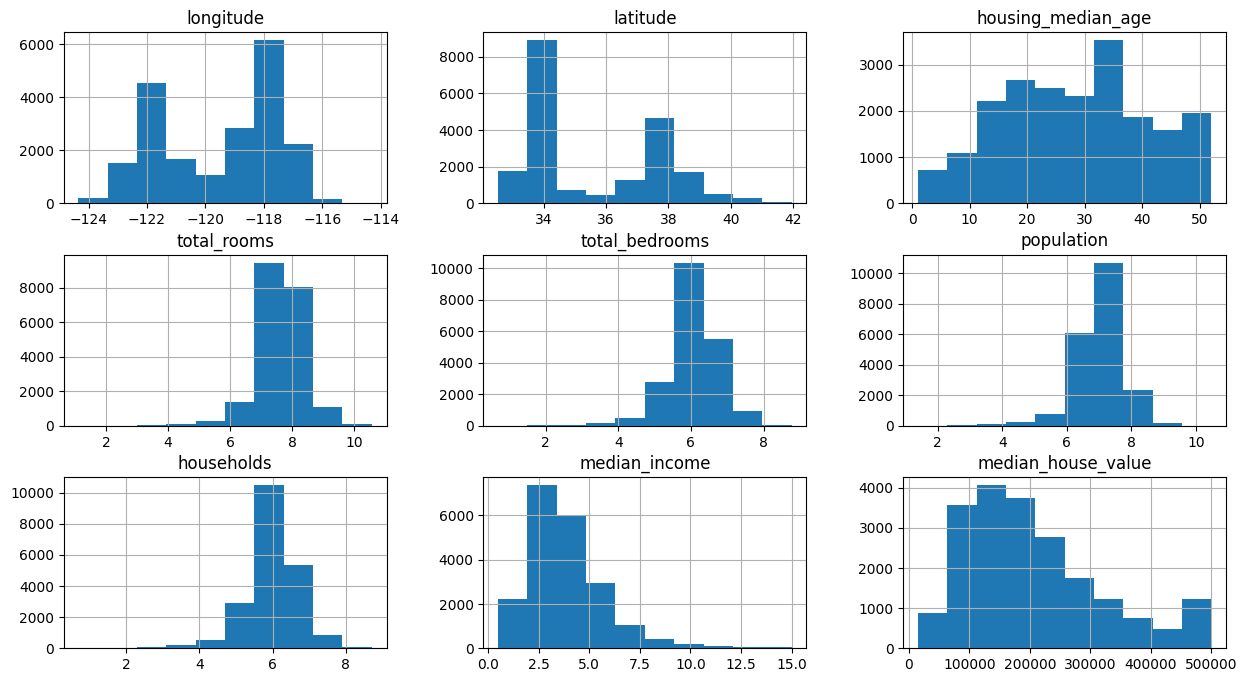

In [8]:
# We have a bunch of right-skewed histograms, so we'll take the log to give us something more 
# resembling a gaussian bell curve

data['total_rooms'] = np.log(data['total_rooms'] + 1)
data['total_bedrooms'] = np.log(data['total_bedrooms'] + 1)
data['population'] = np.log(data['population'] + 1)
data['households'] = np.log(data['households'] + 1)

data.hist(figsize=(15,8))

<Axes: xlabel='latitude', ylabel='longitude'>

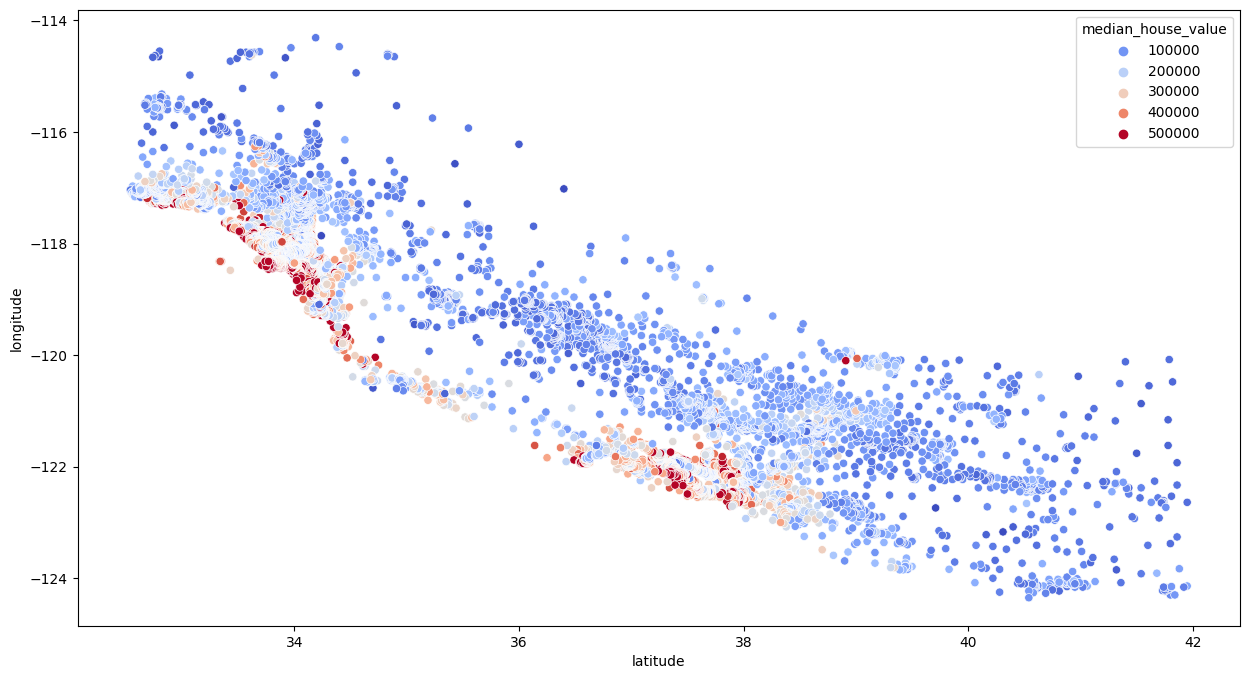

In [9]:
# Let's visualize the coordinates

plt.figure(figsize=(15,8))
sns.scatterplot(x='latitude', y='longitude', data=data, hue='median_house_value', palette='coolwarm')

# The warmer colors are the houses closer to the water (bottom of the plot), and are generally more expensive

<Axes: >

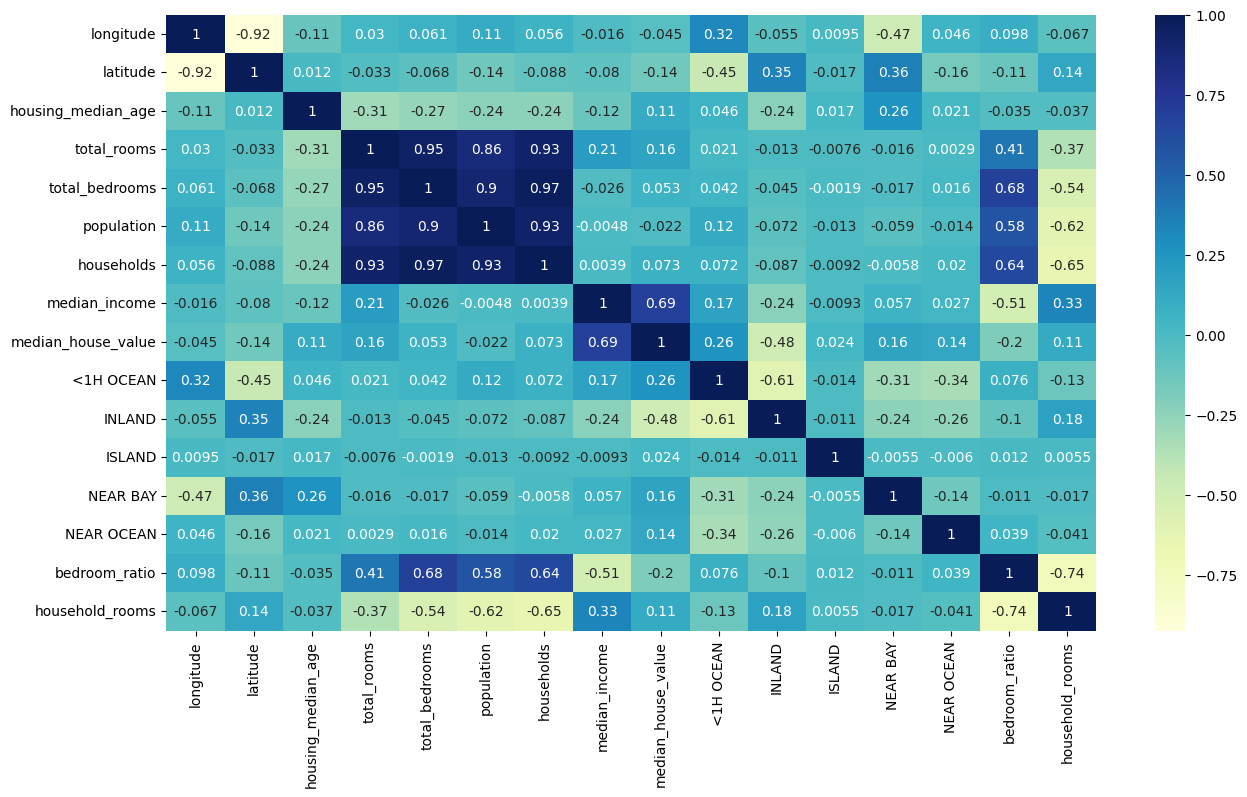

In [10]:
# Feature engineering: let's use total bedrooms and total rooms to find how many rooms are bedrooms

data['bedroom_ratio'] = data['total_bedrooms'] / data['total_rooms']

# We may want to see how much the different plot sizes in the data are affecting this:
# To counter that, we can get the number of rooms per household in a plot of land
data['household_rooms'] = data['total_rooms'] / data['households']

plt.figure(figsize=(15,8))
sns.heatmap(data.corr(), annot=True, cmap='YlGnBu')

In [11]:
# Now to get our training and testing data

# X is all columns except predictor, y is predictor variable

X = data.drop(['median_house_value'], axis=1)
y = data['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# We get our full train dataset back by performing this join

train_data = X_train.join(y_train)
test_data = X_test.join(y_test)
train_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,bedroom_ratio,household_rooms,median_house_value
10251,-117.87,33.89,17.0,7.273786,6.274762,6.646391,6.124683,2.4250,True,False,False,False,False,0.862654,1.187618,171700.0
20271,-119.27,34.17,15.0,9.341719,7.664816,8.110127,7.368970,4.3693,False,False,False,False,True,0.820493,1.267710,423300.0
14318,-117.14,32.70,44.0,6.490724,5.389072,6.768493,5.361292,1.9338,False,False,False,False,True,0.830273,1.210664,89400.0
6415,-118.01,34.14,23.0,8.139149,6.626718,7.697575,6.593045,3.5200,False,True,False,False,False,0.814178,1.234505,187300.0
18037,-121.91,37.23,27.0,8.490233,6.505784,7.579168,6.492240,7.3843,True,False,False,False,False,0.766267,1.307751,405000.0


In [12]:
# Let's train a simple linear regression model

reg = LinearRegression()
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

reg.fit(X_train_scaled, y_train)

LinearRegression()

In [13]:
reg.score(X_test_scaled, y_test)

0.6802789277028234

In [14]:
# Random forest model basic

forest = RandomForestRegressor()

# This will take a while
forest.fit(X_train_scaled, y_train)
forest.score(X_test_scaled, y_test)

0.7480888957581773

In [ ]:
# Let's see if we can get better results with hyperparameter tuning

forest = RandomForestRegressor()

param_grid = {
    'n_estimators': [150, 200, 250],
    'min_samples_split': [2, 4],
    'max_depth': [None, 4, 8],
}

# This will take an even longer while
grid_search = GridSearchCV(
    forest, 
    param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    return_train_score=True
)

grid_search.fit(X_train_scaled, y_train)

In [16]:
# Get best parameters and score the model

best_forest = grid_search.best_estimator_
best_forest.score(X_test_scaled, y_test)

0.7624898942981346